In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data = pd.read_csv("all.csv")
data.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Full2 IQ,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,SourceFile
0,26001,2,1.0,16.92,1.0,pending,pending,pending,pending,pending,...,NaN,120.0,pending,1.0,NaN,NaN,NaN,1.0,NaN,Brown
1,26002,2,1.0,15.68,1.0,pending,pending,pending,pending,pending,...,NaN,107.0,pending,1.0,NaN,NaN,NaN,1.0,NaN,Brown
2,26004,2,0.0,14.99,1.0,pending,pending,pending,pending,pending,...,NaN,125.0,pending,1.0,NaN,NaN,NaN,1.0,NaN,Brown
3,26005,2,0.0,15.16,1.0,pending,pending,pending,pending,pending,...,NaN,126.0,pending,1.0,NaN,NaN,NaN,1.0,NaN,Brown
4,26009,2,1.0,16.91,0.0,pending,pending,pending,pending,pending,...,NaN,97.0,pending,1.0,NaN,NaN,NaN,1.0,NaN,Brown


In [3]:
columns_to_drop = [
    'ScanDir ID',       
    'Site',            
    'SourceFile',      
    'ADHD Measure',   
    'IQ Measure',     
    'QC_Rest_1',    
    'QC_Rest_2',        
    'QC_Rest_3',        
    'QC_Rest_4',       
    'QC_Anatomical_1',  
    'QC_Anatomical_2',
    'Full2 IQ',
    'Secondary Dx',

]

data = data.drop(columns=columns_to_drop, errors='ignore')
data.head()

,Gender,Age,Handedness,DX,ADHD Index,Inattentive,Hyper/Impulsive,Verbal IQ,Performance IQ,Full4 IQ,Med Status
0,1.0,16.92,1.0,pending,pending,pending,pending,133.0,104.0,120.0,pending
1,1.0,15.68,1.0,pending,pending,pending,pending,106.0,106.0,107.0,pending
2,0.0,14.99,1.0,pending,pending,pending,pending,119.0,123.0,125.0,pending
3,0.0,15.16,1.0,pending,pending,pending,pending,116.0,131.0,126.0,pending
4,1.0,16.91,0.0,pending,pending,pending,pending,113.0,81.0,97.0,pending


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 0 to 631
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           631 non-null    float64
 1   Age              632 non-null    float64
 2   Handedness       631 non-null    float64
 3   DX               632 non-null    object 
 4   ADHD Index       416 non-null    object 
 5   Inattentive      495 non-null    object 
 6   Hyper/Impulsive  495 non-null    object 
 7   Verbal IQ        505 non-null    float64
 8   Performance IQ   505 non-null    float64
 9   Full4 IQ         584 non-null    float64
 10  Med Status       495 non-null    object 
dtypes: float64(6), object(5)
memory usage: 54.4+ KB


In [4]:
data.head(-20)

,Gender,Age,Handedness,DX,ADHD Index,Inattentive,Hyper/Impulsive,Verbal IQ,Performance IQ,Full4 IQ,Med Status
0,1.0,16.92,1.0,pending,pending,pending,pending,133.0,104.0,120.0,pending
1,1.0,15.68,1.0,pending,pending,pending,pending,106.0,106.0,107.0,pending
2,0.0,14.99,1.0,pending,pending,pending,pending,119.0,123.0,125.0,pending
3,0.0,15.16,1.0,pending,pending,pending,pending,116.0,131.0,126.0,pending
4,1.0,16.91,0.0,pending,pending,pending,pending,113.0,81.0,97.0,pending
...,...,...,...,...,...,...,...,...,...,...,...
607,1.0,11.03,1.0,0,NaN,NaN,NaN,-999.0,-999.0,130.0,NaN
608,1.0,12.71,1.0,0,NaN,NaN,NaN,-999.0,-999.0,99.0,NaN
609,1.0,13.68,1.0,0,NaN,NaN,NaN,-999.0,-999.0,99.0,NaN
610,1.0,13.03,1.0,0,NaN,NaN,NaN,-999.0,-999.0,111.0,NaN


In [5]:
nan_counts = data.isna().sum()
pending_counts = data.apply(lambda x: (x == 'pending').sum())
minus999_counts = data.apply(lambda x: (x == -999).sum())

invalid_counts = pd.DataFrame({
    'NaN': nan_counts,
    '-999': minus999_counts,
    'pending': pending_counts
})

invalid_counts['Total Invalid'] = invalid_counts.sum(axis=1)
invalid_counts['Valid Values'] = 632 - invalid_counts['Total Invalid']
invalid_counts['Valid %'] = (invalid_counts['Valid Values'] / 632) * 100

print(invalid_counts)

for col in data.columns:
    valid = invalid_counts.loc[col, 'Valid Values']
    valid_pct = invalid_counts.loc[col, 'Valid %']
    print(f"{col}: {valid} valid values ({valid_pct:.2f}% out of 632")

                 NaN  -999  pending  Total Invalid  Valid Values     Valid %
Gender             1     0        0              1           631   99.841772
Age                0     0        0              0           632  100.000000
Handedness         1     6        0              7           625   98.892405
DX                 0     0       26             26           606   95.886076
ADHD Index       216     0       26            242           390   61.708861
Inattentive      137     0       26            163           469   74.208861
Hyper/Impulsive  137     0       26            163           469   74.208861
Verbal IQ        127    52        0            179           453   71.677215
Performance IQ   127    52        0            179           453   71.677215
Full4 IQ          48    10        0             58           574   90.822785
Med Status       137     0       26            163           469   74.208861
Gender: 631 valid values (99.84% out of 632
Age: 632 valid values (100.00% o

In [6]:
data_cleaned = data.dropna(subset=['DX'])
for col in ['Gender', 'Handedness']:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])

numeric_cols = ['ADHD Index', 'Inattentive', 'Hyper/Impulsive', 'Verbal IQ', 'Performance IQ', 'Full4 IQ']
for col in numeric_cols:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mean())

data_cleaned['Med Status'] = data_cleaned['Med Status'].fillna(data_cleaned['Med Status'].mode()[0])

for col in ['ADHD Index', 'Inattentive', 'Hyper/Impulsive']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

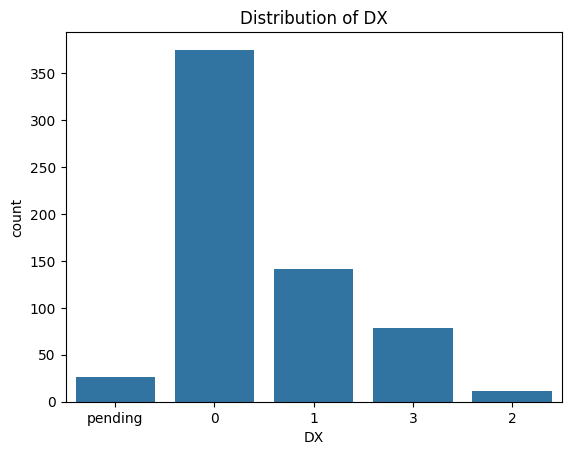

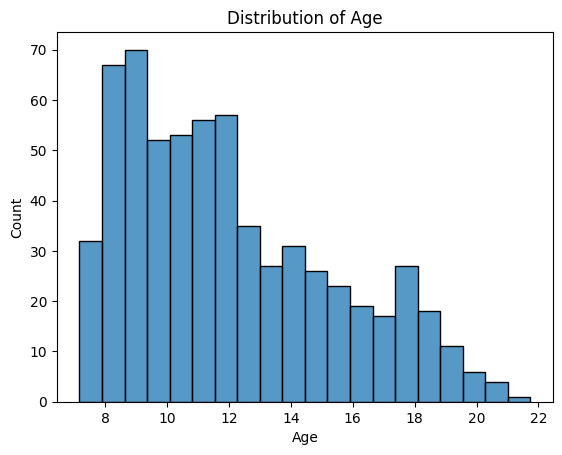

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='DX', data=data_cleaned)
plt.title('Distribution of DX')
plt.show()

sns.histplot(data_cleaned['Age'], bins=20)
plt.title('Distribution of Age')
plt.show()

In [8]:
data_cleaned = data_cleaned[~data_cleaned.isin([-999, 'pending']).any(axis=1)]
data_cleaned = data_cleaned.dropna()

In [9]:
data_cleaned.head()

,Gender,Age,Handedness,DX,ADHD Index,Inattentive,Hyper/Impulsive,Verbal IQ,Performance IQ,Full4 IQ,Med Status
26,0.0,10.73,1.0,0,47.0,55.0,43.0,121.0,119.0,122.0,1
27,0.0,12.99,1.0,1,90.0,89.0,78.0,122.0,108.0,106.0,1
28,0.0,8.12,1.0,0,42.0,42.0,43.0,85.0,98.0,89.0,1
29,0.0,10.81,1.0,0,42.0,49.0,49.0,85.0,86.0,97.0,1
30,0.0,12.65,1.0,1,87.0,90.0,90.0,89.0,88.0,89.0,1


In [ ]:
import pandas as pd

data_cleaned['DX'] = pd.to_numeric(data_cleaned['DX'], errors='coerce').astype('Int64')  
data_cleaned = data_cleaned.dropna(subset=['DX']) 

data_cleaned['Med Status'] = pd.to_numeric(data_cleaned['Med Status'], errors='coerce').astype('Int64')
data_cleaned['Med Status'] = data_cleaned['Med Status'].fillna(data_cleaned['Med Status'].mode()[0])

print(data_cleaned['DX'].dtype)  
print(data_cleaned['DX'].value_counts()) 
print(data_cleaned['Med Status'].dtype)  
print(data_cleaned['Med Status'].value_counts()) 

Int64
DX
0    309
1    138
3     74
2     11
Name: count, dtype: Int64
Int64
Med Status
1       403
-999     73
2        56
Name: count, dtype: Int64


In [11]:
import pandas as pd
import numpy as np

data_cleaned['Med Status'] = data_cleaned['Med Status'].replace('pending', -999)

print(data_cleaned['Med Status'].value_counts(dropna=False))

np.random.seed(42)  
mask = data_cleaned['Med Status'] == -999
n_missing = mask.sum() 
n_1 = int(0.8 * n_missing) 
n_2 = n_missing - n_1     
replacements = [1] * n_1 + [2] * n_2
np.random.shuffle(replacements)

data_cleaned.loc[mask, 'Med Status'] = replacements

data_cleaned['Med Status'] = pd.to_numeric(data_cleaned['Med Status'], errors='coerce').astype('Int64')

print(data_cleaned['Med Status'].value_counts(dropna=False))

Med Status
1       403
-999     73
2        56
Name: count, dtype: Int64
Med Status
1    461
2     71
Name: count, dtype: Int64


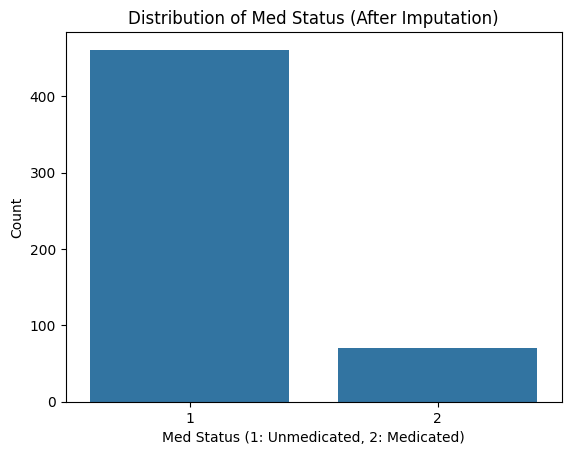

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Med Status', data=data_cleaned)
plt.title('Distribution of Med Status (After Imputation)')
plt.xlabel('Med Status (1: Unmedicated, 2: Medicated)')
plt.ylabel('Count')
plt.show()

In [13]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 26 to 629
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           532 non-null    float64
 1   Age              532 non-null    float64
 2   Handedness       532 non-null    float64
 3   DX               532 non-null    Int64  
 4   ADHD Index       532 non-null    float64
 5   Inattentive      532 non-null    float64
 6   Hyper/Impulsive  532 non-null    float64
 7   Verbal IQ        532 non-null    float64
 8   Performance IQ   532 non-null    float64
 9   Full4 IQ         532 non-null    float64
 10  Med Status       532 non-null    Int64  
dtypes: Int64(2), float64(9)
memory usage: 50.9 KB


In [14]:
data_cleaned['Age'] = np.floor(data_cleaned['Age']).astype('Int64')
print(data_cleaned['Age'].describe())
print(data_cleaned['Age'].value_counts(dropna=False))

count        532.0
mean     11.169173
std       3.224428
min            7.0
25%            9.0
50%           10.0
75%           13.0
max           21.0
Name: Age, dtype: Float64
Age
8     89
9     83
11    74
10    61
12    42
14    36
7     34
13    28
17    22
15    18
16    15
18    14
19     8
20     7
21     1
Name: count, dtype: Int64


In [15]:
data_cleaned.head()

,Gender,Age,Handedness,DX,ADHD Index,Inattentive,Hyper/Impulsive,Verbal IQ,Performance IQ,Full4 IQ,Med Status
26,0.0,10,1.0,0,47.0,55.0,43.0,121.0,119.0,122.0,1
27,0.0,12,1.0,1,90.0,89.0,78.0,122.0,108.0,106.0,1
28,0.0,8,1.0,0,42.0,42.0,43.0,85.0,98.0,89.0,1
29,0.0,10,1.0,0,42.0,49.0,49.0,85.0,86.0,97.0,1
30,0.0,12,1.0,1,87.0,90.0,90.0,89.0,88.0,89.0,1


In [16]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 26 to 629
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           532 non-null    float64
 1   Age              532 non-null    Int64  
 2   Handedness       532 non-null    float64
 3   DX               532 non-null    Int64  
 4   ADHD Index       532 non-null    float64
 5   Inattentive      532 non-null    float64
 6   Hyper/Impulsive  532 non-null    float64
 7   Verbal IQ        532 non-null    float64
 8   Performance IQ   532 non-null    float64
 9   Full4 IQ         532 non-null    float64
 10  Med Status       532 non-null    Int64  
dtypes: Int64(3), float64(8)
memory usage: 51.4 KB


In [17]:
data_cleaned.to_csv('cleaned_data.csv', index=False)


### Model Results: Random Forest ###
Accuracy: 0.8411
F1-Score: 0.8461

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       0.72      0.77      0.74        30
           2       0.59      0.67      0.62        15

    accuracy                           0.84       107
   macro avg       0.76      0.78      0.77       107
weighted avg       0.85      0.84      0.85       107



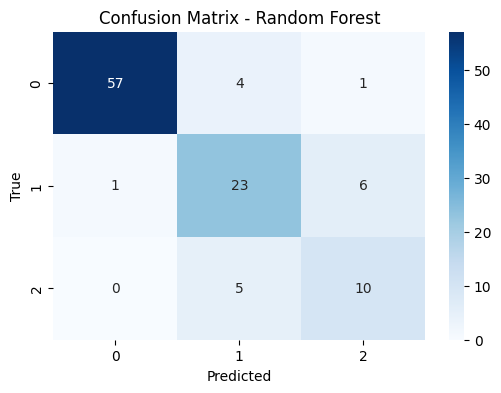

ROC AUC (weighted) for Random Forest: 0.9581

### Model Results: Logistic Regression ###
Accuracy: 0.7944
F1-Score: 0.8044

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.88        62
           1       0.65      0.80      0.72        30
           2       0.58      0.73      0.65        15

    accuracy                           0.79       107
   macro avg       0.74      0.78      0.75       107
weighted avg       0.83      0.79      0.80       107



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


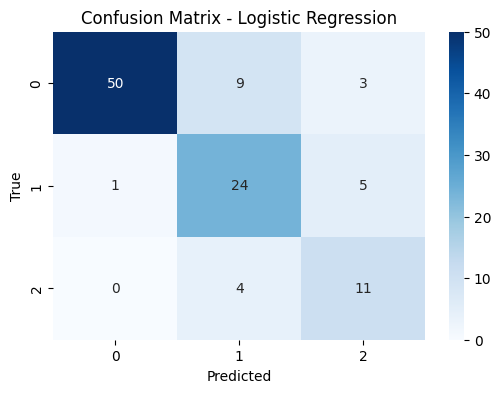

ROC AUC (weighted) for Logistic Regression: 0.9511

### Model Results: SVM ###
Accuracy: 0.8318
F1-Score: 0.8366

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       0.70      0.77      0.73        30
           2       0.56      0.60      0.58        15

    accuracy                           0.83       107
   macro avg       0.75      0.76      0.75       107
weighted avg       0.84      0.83      0.84       107



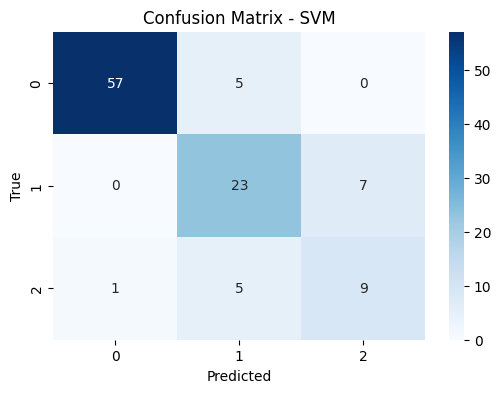

ROC AUC (weighted) for SVM: 0.9536

### Model Results: KNN ###
Accuracy: 0.7570
F1-Score: 0.7648

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        62
           1       0.65      0.67      0.66        30
           2       0.39      0.47      0.42        15

    accuracy                           0.76       107
   macro avg       0.66      0.67      0.66       107
weighted avg       0.77      0.76      0.76       107



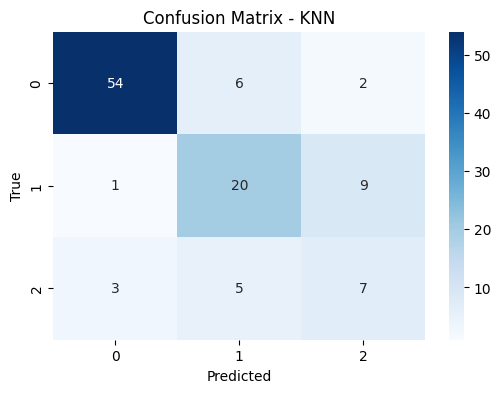

ROC AUC (weighted) for KNN: 0.9036

### Model Results: XGBoost ###
Accuracy: 0.8598
F1-Score: 0.8626

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        62
           1       0.79      0.73      0.76        30
           2       0.63      0.80      0.71        15

    accuracy                           0.86       107
   macro avg       0.79      0.82      0.81       107
weighted avg       0.87      0.86      0.86       107



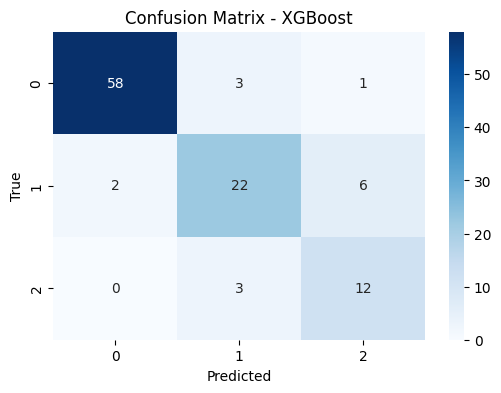

ROC AUC (weighted) for XGBoost: 0.9612


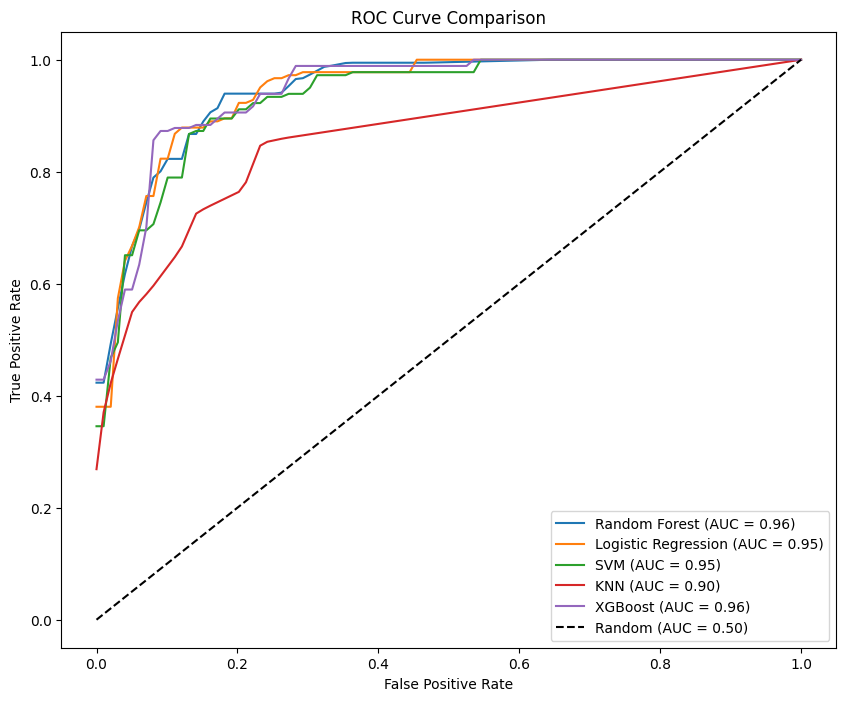


### Comparing Model Performance ###
                     Accuracy  F1-Score   ROC-AUC
Random Forest        0.841121  0.846103  0.958123
Logistic Regression  0.794393  0.804352  0.951091
SVM                  0.831776  0.836584  0.953615
KNN                  0.757009  0.764820  0.903624
XGBoost              0.859813  0.862595  0.961220

Best Model by F1-Score: XGBoost
Best Model by ROC-AUC: XGBoost


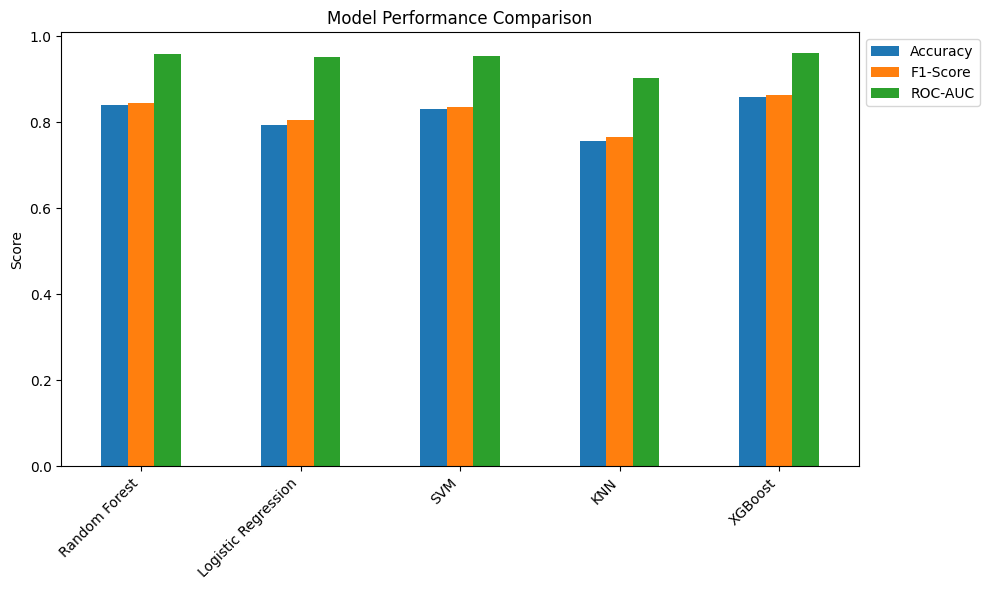

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

data_cleaned = pd.read_csv('cleaned_data.csv')

data_cleaned['DX'] = data_cleaned['DX'].replace(2, 1)
data_cleaned['DX'] = data_cleaned['DX'].replace({0: 0, 1: 1, 3: 2})

X = data_cleaned.drop(columns=['DX'])
y = data_cleaned['DX']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

class_weights = {0: 1, 1: 2, 2: 2}

models = {
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42),
    'Logistic Regression': LogisticRegression(class_weight=class_weights, multi_class='multinomial', max_iter=1000, random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(num_class=3, objective='multi:softmax', random_state=42)
}

results = {}
roc_data = {}

unique_labels = np.unique(y)
y_test_bin = label_binarize(y_test, classes=unique_labels)

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1}
    
    print(f"\n### Model Results: {name} ###")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        mean_fpr = np.linspace(0, 1, 100)
        tpr_sum = np.zeros_like(mean_fpr)
        
        for i, label in enumerate(unique_labels):
            fpr, tpr, _ = roc_curve(y_test == label, y_prob[:, i])
            tpr_sum += np.interp(mean_fpr, fpr, tpr)
        
        mean_tpr = tpr_sum / len(unique_labels)
        roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
        results[name]['ROC-AUC'] = roc_auc
        roc_data[name] = {'fpr': mean_fpr, 'tpr': mean_tpr, 'auc': roc_auc}
        print(f"ROC AUC (weighted) for {name}: {roc_auc:.4f}")
    else:
        results[name]['ROC-AUC'] = np.nan
        print(f"Model {name} does not support probability predictions for ROC AUC.")

plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{name} (AUC = {data["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print("\n### Comparing Model Performance ###")
results_df = pd.DataFrame(results).T
print(results_df[['Accuracy', 'F1-Score', 'ROC-AUC']])

best_model_name = results_df['F1-Score'].idxmax()
print(f"\nBest Model by F1-Score: {best_model_name}")

if 'ROC-AUC' in results_df.columns:
    best_auc_model = results_df['ROC-AUC'].idxmax()
    print(f"Best Model by ROC-AUC: {best_auc_model}")

results_df[['Accuracy', 'F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.show()

In [20]:
import joblib
import pandas as pd

best_model = models['XGBoost']  

joblib.dump(best_model, 'adhd_model.pkl')
joblib.dump(scaler, 'adhd_scaler.pkl')
joblib.dump(X.columns.tolist(), 'adhd_feature_names.pkl')

print("Model, scaler, and feature names saved successfully!")

Model, scaler, and feature names saved successfully!


In [26]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load('adhd_model.pkl')
scaler = joblib.load('adhd_scaler.pkl')
feature_names = joblib.load('adhd_feature_names.pkl')

def predict_adhd(new_data):
    """
    Input: dict or DataFrame row with same columns as training data
    Output: Predicted DX (0: Healthy, 1: ADHD, 2: Other)
    """
    df = pd.DataFrame([new_data])
    
    # Add missing columns with NaN
    missing_cols = set(feature_names) - set(df.columns)
    for col in missing_cols:
        df[col] = np.nan
    
    df = df[feature_names]
    df_scaled = scaler.transform(df)
    
    prediction = model.predict(df_scaled)[0]
    probability = model.predict_proba(df_scaled)[0]
    labels = {0: "Healthy (No ADHD)", 1: "ADHD", 2: "Other Diagnosis"}
    
    return {
        'prediction': labels[prediction],
        'confidence': float(np.max(probability)),
        'probabilities': {
            labels[i]: round(float(prob), 4) for i, prob in enumerate(probability)
        }
    }

if __name__ == "__main__":
    sample_input = {
        'Gender': 1,           # 1 = Male, 0 = Female
        'Age': 12.5,
        'Handedness': 1,       # 1 = Right-handed
        'ADHD Index': 65,
        'Inattentive': 8,
        'Hyper/Impulsive': 7,
        'Verbal IQ': 95,
        'Performance IQ': 88,
        'Full4 IQ': 91,
        'Med Status': 4        # 0 = No medication
    }

    result = predict_adhd(sample_input)
    print("\nPrediction Result:")
    print(f"Diagnosis: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print("Class Probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.2%}")


Prediction Result:
Diagnosis: ADHD
Confidence: 65.65%
Class Probabilities:
  Healthy (No ADHD): 27.33%
  ADHD: 65.65%
  Other Diagnosis: 7.02%
